# MAMBO deep learning inference

# Overview

* Install and run a model that should extract shrub outlines from imagery
* Deeper dive into what's happening and hwo to bring your own data
* A look at _explainability_ tools that show us what the model is seeing
* Using the output as input for height estimation from surface data

## Setup

This will be much faster with a `GPU runtime`. At the top of this page, select `Runtime` ... `Change runtime type` ... `T4 GPU`.

The workshop will save all the output data to the machine that hosts its notebook, which will disappear after it's shut down! You might want to save copies inside Google Drive - connect to it like this, and approve the pop-up windows.



Next, install the packages we need - the Attention Unet model, and functions for handling the GeoTIFF data and exporting polygons.

The installation will take many seconds to a minute to run; if you restart the notebook it will recognise what's already been installed.

In [ ]:
%pip install git+https://github.com/MAMBO-Horizon-WP4/att-unet-shrub-id.git

  Cloning https://github.com/MAMBO-Horizon-WP4/att-unet-shrub-id.git to /tmp/pip-req-build-89belwrm
  Running command git clone --filter=blob:none --quiet https://github.com/MAMBO-Horizon-WP4/att-unet-shrub-id.git /tmp/pip-req-build-89belwrm
  Resolved https://github.com/MAMBO-Horizon-WP4/att-unet-shrub-id.git to commit a00f815f85d97273e7b3e3de81fab5e307339cb8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import os
import shutil
import io
import s3fs
from pathlib import Path
import shrubnet
from shrubnet.model import AttentionUNet
from shrubnet.dataset import RSDataset
from shrubnet.inference import run_inference
from shrubnet.train import train_model
import torch
from torchvision.transforms.functional import to_tensor
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.plot import show, reshape_as_image, reshape_as_raster


Set these environment variables that show which cloud-based storage to connect to.

In our example, the data is hosted at [JASMIN object store](https://help.jasmin.ac.uk/docs/short-term-project-storage/using-the-jasmin-object-store/)

Data hosted in the [AWS s3 store](https://aws.amazon.com/s3/) could be read in the same way (it would slightly need different options, for example not needing to set an `ENDPOINT`)

In [ ]:

os.environ['AWS_S3_ENDPOINT'] = 'ukcehdrs-o.s3-ext.jc.rl.ac.uk'
os.environ['AWS_ENDPOINT_URL'] = 'https://ukcehdrs-o.s3-ext.jc.rl.ac.uk'
os.environ['AWS_VIRTUAL_HOSTING']="False"
os.environ['AWS_HTTPS']="True"
os.environ['AWS_NO_SIGN_REQUEST'] = "True"
os.environ['AWS_SECRET_ACCESS_KEY'] = ""


s3 = s3fs.S3FileSystem(anon=True)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
drive_path =  Path("/content/drive/MyDrive/mambo_data/")

## Load a pre-trained model

Our _model weights_ are also kept in object storage. This is a pre-trained model used for shrub detection from 3 band RGB imagery.

First we define our model:

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AttentionUNet().to(device)

And then read the weights from object storage, and load them into the model.

If you had a local file with the weights, this would look like

`model.load_state_dict(torch.load("best_model.pth"))`


### Path 1: load pre-trained weights from s3

This is a small test model, trained on Colab for about 30 epochs with image augmentations. It's a slightly more developed version of the one from the second notebook in the tutorial.

You might notice the ";" character at the end and think "that's not python!". It's Jupyter notebook syntax to avoid printing out any output from the last line. If you remove it, you'll see a read-out of all the model's layers.

In [ ]:
model_state = "s3://attn-unet-shrub-id/model_weights/best_model.pth"

with s3.open(model_state) as state:
    buffer = io.BytesIO(state.read())
    model.load_state_dict(torch.load(buffer))

model.eval;

## Path 2: Load the weights from Exercise 2

If you ran the second notebook right before this one, you'll have your own set of model weights saved in Google Drive.

The **folder they are stored in is named by timestamp** - please check the timestamp in your Drive (it will be underneath the `mambo_data` directory) and replace the value of `timestamp` below.

In [ ]:
timestamp = 'my_timestamp_here'

model_path = drive_path / timestamp / 'model_state/best_model.pth'
model.load_state_dict(torch.load(model_path, map_location=device))

## Step by step through inference

We hand an image to the model, and it returns its estimate of how likely each pixel is to be part of a shrub, or not. We'll go through these steps:

* Read an area of the image
* Normalise the pixel values, in the same way we did for the training data
* Turn the image into a `tensor` and put it on the GPU
* Give the tensor to the model, and it returns a set of predictions

We're picking an arbitrary area of the image, the first 2048 x 2048 pixels.

If an object we're interested in is at the edge and we can't see the whole outline, we may be less likely to detect it - thus approaches which use a sliding window and take an average of the pixel values in overlapping windows.

In [ ]:
window = Window(0, 0, 2048, 2048)
with rasterio.open("s3://attn-unet-shrub-id/data/Strawberry_labelled_area_test.tif") as src:
    data = src.read(window=window)

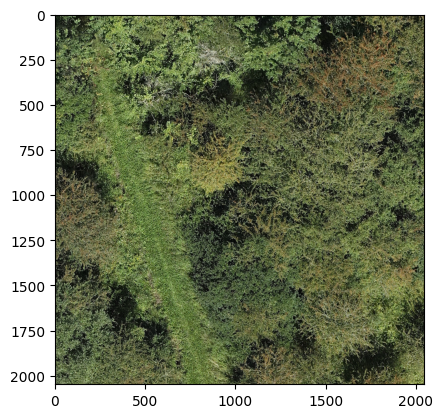

<Axes: >

In [ ]:
show(data)

If you've come from Exercise 2 of this notebook, you'll already have a JSON file with the mean and standard deviation values per band that were used during model training. It should be inside the `mambo_data` directory.

If you're just running this notebook then please download this version of it instead

In [ ]:
# Optional! Download a fresh copy of means_stds.json
s3.download('s3://attn-unet-shrub-id/data/means_stds.json', drive_path / 'means_stds.json');

In [ ]:
import json
from torchvision import transforms
stats = json.load(open(drive_path / 'means_stds.json'))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(stats['means'], stats['stds'])
])

We use the convenient [reshape_as_image](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.reshape_as_image) function provded by `rasterio` to swap the axes order from (bands, rows, columns) - the TIFF format - to (rows, columns, bands) - what the model expects.

`unsqueeze` here adds an extra dimension - the model accepts a batch of images, here we're telling it that it's a batch of one.

`to` is copying the image data onto the GPU

In [ ]:
window_tensor = transform(reshape_as_image(data)).unsqueeze(0).float().to(torch.device('cuda'))

We put the model in evaluation mode - it's not going to learn from the data we show it here

In [ ]:
model.eval()
with torch.no_grad():
    output = model(window_tensor).float().cpu().numpy().squeeze(axis=1)

The result is a list of list of predictions, each one corresponding to a pixel location:

In [ ]:
output.shape

(1, 2048, 2048)

The values aren't exactly probabilities, but we can interpret them as a kind of heatmap of shrub likeliness.

_Side note_: if you try this without loading the weights into the model, you'll see results that look like random noise

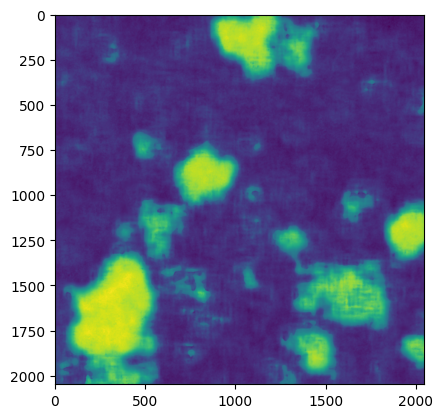

<Axes: >

In [ ]:
show(reshape_as_raster(output))

The threshold value of 0.5 offers a much harder edge to our shrub predictions

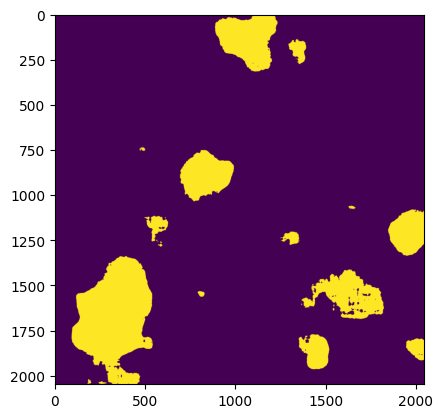

<Axes: >

In [ ]:
show(reshape_as_raster(output > 0.5))

While far from perfect, it's a reasonable result for a tiny model that has trained for an hour or two on a free GPU

In [ ]:
s3.ls('s3://attn-unet-shrub-id/data/')

['attn-unet-shrub-id/data/',
 'attn-unet-shrub-id/data/256',
 'attn-unet-shrub-id/data/256_split',
 'attn-unet-shrub-id/data/512',
 'attn-unet-shrub-id/data/Strawberry_labelled_area_test.tif',
 'attn-unet-shrub-id/data/Strawberry_unlabelled_area.tif',
 'attn-unet-shrub-id/data/means_stds.json',
 'attn-unet-shrub-id/data/test',
 'attn-unet-shrub-id/data/train']

The same view for another part of the Strawberry Hill drone survey site for which we don't have any shrub labels:

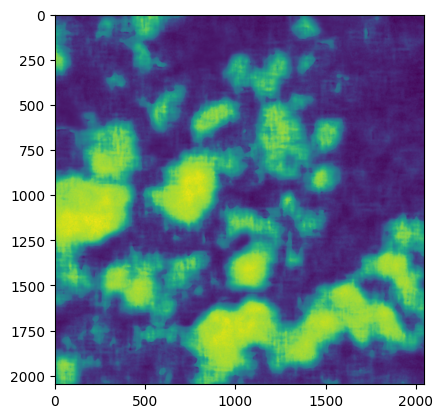

<Axes: >

In [ ]:
window = Window(256, 256, 2048, 2048)

with rasterio.open("https://ukcehdrs-o.s3-ext.jc.rl.ac.uk/attn-unet-shrub-id/data/Strawberry_unlabelled_area.tif") as src:
    data = src.read(window=window)

window_tensor = transform(reshape_as_image(data)).unsqueeze(0).float().to(torch.device('cuda'))
with torch.no_grad():
    output = model(window_tensor).float().cpu().numpy().squeeze(axis=1)

show(output)